In [39]:
from transformers import ViTFeatureExtractor, ViTModel
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler
from torchmetrics.functional import accuracy

from PIL import Image
import numpy as np
import glob
import os
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc
from sklearn.model_selection import train_test_split

In [2]:
# Hyperparams
epochs = 1
batch_size = 16
learing_rate = 2e-5
eps = 1e-8

# Load data
- Lets load list our data first

In [3]:
labels = sorted([os.path.basename(folder_path) for folder_path in glob.glob('data/asl_alphabet_train/asl_alphabet_train/*')])
labels_index = dict([(label, index) for index, label in enumerate(labels)])
index_labels = dict([(index, label) for index, label in enumerate(labels)])

In [4]:
image_files = glob.glob('data/asl_alphabet_train/asl_alphabet_train/**/*.jpg', recursive=True)

In [5]:
# Split dataset
train_images, test_images = train_test_split(image_files, test_size=0.2, random_state=2021)

# Lets inherit the vit model and add some linear layers at the bottom
- We wiil build a simple vit model to do some simple classsification

In [6]:
class ViTHandSign(nn.Module):
    def __init__(self):
        super(ViTHandSign, self).__init__()
        self.vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.fc1 = nn.Linear(self.vit_model.config.hidden_size, 256)
        self.dropout = nn.Dropout(0.25)
        self.output = nn.Linear(256, len(labels))
        
    def forward(self, x):
        x = self.vit_model(pixel_values=x)
        outputs = x[0]
        
        x = self.dropout(outputs[:, 0, :])
        x = self.fc1(x)
        return self.output(x)

In [7]:
model = ViTHandSign()
model.to('cuda')

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTHandSign(
  (vit_model): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=30

# Lets prepare data
- Using the feature extractor class we can normalize and resize our images in an instant
- We will write a wrapper around our dataset class
- Then load into our dataloader

In [8]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224') 

In [9]:
class HandSignDataset(Dataset):
    def __init__(self, image_list, labels_index, feature_extractor):
        super(HandSignDataset, self).__init__()
        self.image_list = image_list
        self.labels_index = labels_index
        self.feature_extractor = feature_extractor
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image_path = self.image_list[index]
        img = Image.open(image_path)
        base_path = os.path.basename(os.path.dirname(image_path))
        
        features = self.feature_extractor(img, return_tensors='pt')
        labels = self.labels_index[base_path]
        
        return features['pixel_values'].squeeze(0), labels

In [10]:
train_dataset = HandSignDataset(train_images, labels_index, feature_extractor)
test_dataset = HandSignDataset(test_images, labels_index, feature_extractor)

In [11]:
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size, num_workers=6)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size, num_workers=6)

# Lets train
- I normally try to use pytorch lighthing for such scenarios lately but for this repo
- Lets write the training loop

In [12]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=learing_rate, eps=eps)

In [13]:
for epoch in tqdm(range(1)):
    model.train()
    
    training_loss = 0
    for step, (train_image, train_labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        train_batch_image = train_image.to('cuda')
        train_batch_labels = train_labels.to('cuda')
        
        # Forward pass
        optim.zero_grad()
        logits = model(train_batch_image)
        
        # Backward pass
        loss = criterion(logits, train_batch_labels)
        loss.backward()
        training_loss += loss.item()
        optim.step()
        
    print('[Epoch %d] Training loss: %.3f' %(epoch + 1, training_loss/ len(train_dataloader)))
        
    model.eval()
    preds = []
    targets = []
    
    test_loss = 0
    for step, (test_image, test_labels) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        test_batch_image = test_image.to('cuda')
        test_batch_label = test_labels.to('cuda')
        targets.append(test_labels)
        
        with torch.no_grad():
            logits = model(test_batch_image)
        
        loss = criterion(logits, test_batch_label)
        test_loss += loss.item()
        
        preds.append(logits.detach().cpu().numpy().argmax(axis=1))
    
    preds = torch.tensor(np.concatenate(preds))
    targets = torch.tensor(np.concatenate(targets))
    print('[Epoch %d] Test loss: %.3f' %(epoch + 1, test_loss/ len(test_dataloader)))
    print('Accuracy: {}'.format(round(accuracy(target=targets, preds=preds).item() * 100)))

NameError: name 'training_loader' is not defined

# Evaluate the model

In [16]:
model.eval()

preds = []
targets = []
for step, (test_image, test_labels) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    targets.append(test_labels)
    with torch.no_grad():
        test_batch_image = test_image.to('cuda')
        logits = model(test_batch_image)
        
        preds.append(logits.detach().cpu().numpy().argmax(axis=1))
    
preds = np.concatenate(preds)
targets = np.concatenate(targets)

In [19]:
print(classification_report(targets, preds, target_names=labels))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       631
           B       1.00      1.00      1.00       582
           C       1.00      1.00      1.00       574
           D       1.00      1.00      1.00       603
           E       1.00      1.00      1.00       631
           F       1.00      1.00      1.00       597
           G       1.00      1.00      1.00       624
           H       1.00      1.00      1.00       560
           I       1.00      1.00      1.00       605
           J       1.00      1.00      1.00       554
           K       1.00      1.00      1.00       584
           L       1.00      1.00      1.00       598
           M       1.00      1.00      1.00       615
           N       1.00      1.00      1.00       586
           O       1.00      1.00      1.00       590
           P       1.00      1.00      1.00       597
           Q       1.00      1.00      1.00       610
           R       1.00    

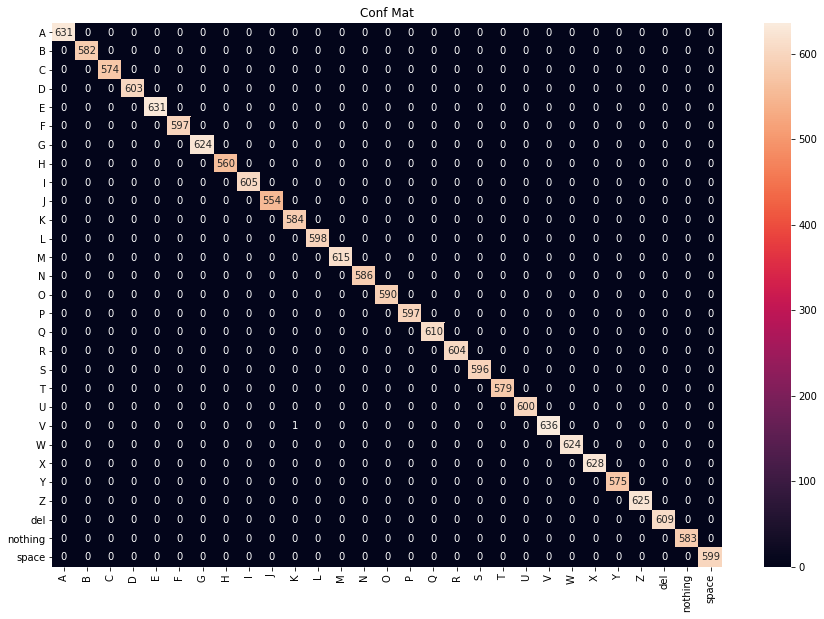

In [22]:
plt.figure(figsize=(15, 10))
plt.title('Conf Mat')
sns.heatmap(
    confusion_matrix(targets, preds), fmt='d', annot=True,
    xticklabels=labels, yticklabels=labels
);

In [26]:
print('MCC: {}'.format(round(matthews_corrcoef(targets, preds) * 100, 2)))

MCC: 99.99


0.0
3.75
7.21
10.64
14.25
17.98
21.57
25.19
28.59
32.1
35.45
38.96
42.56
46.15
49.64
53.18
56.77
60.38
63.95
67.43
70.96
74.63
78.43
82.17
85.64
89.32
92.96
96.44
100.0


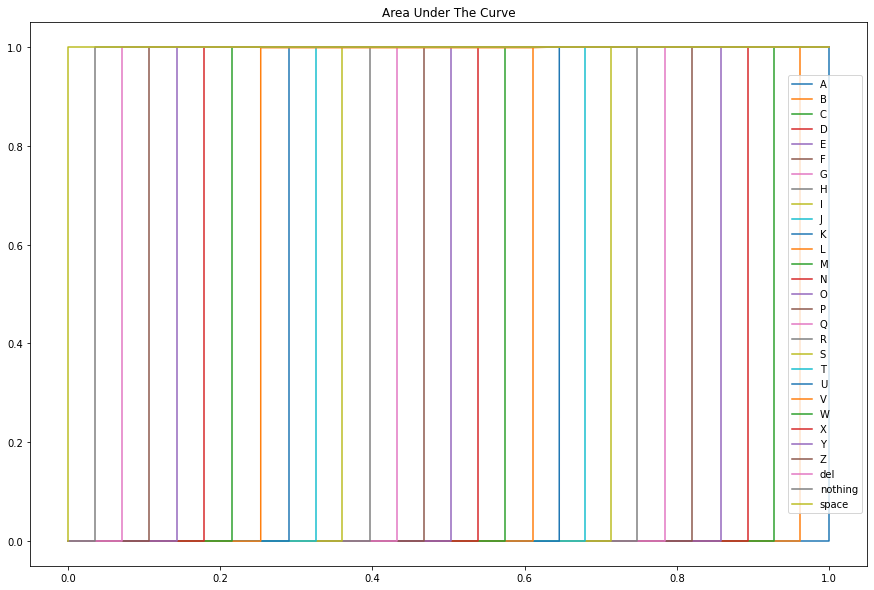

In [41]:
# Area Under The Curve
plt.figure(figsize=(15, 10))
plt.title('Area Under The Curve')
for indexes in index_labels:
    fpr, tpr, thresholds = roc_curve(targets, preds, pos_label=indexes)
    plt.plot(fpr, tpr, label=index_labels[indexes])
    print(round(auc(fpr, tpr) * 100, 2))
    
plt.legend()